subset of categories: cougar_face, helicopter, pizza, helicopter

- select a set of training images
- extract SIFT features from training images (ignore position, orientation and scale)
- Concatenate features into matrix, one descriptor per row

# Roland's understanding and explination of how this system will work:

SIFT calculates keypoints (e.g. 100+) for a grayscale image based on black magic we dont need to know. For each keypoint it calculates a descriptor. 

A descriptor is a 128-dim vector that represents 8 gradient orientations of 4x4 subgrid pixels around the pixel at a keypoint.

We dont care about the keypoint info here and also dont need to track which descriptors are for which image, when building the model.

This huge list of large dim vectors is (unsupervised & unlabled) clustered into groups by similarity of their 128-dim vector values. K-means clusering does the magic for us here. So each cluster contains a bunch of these vectors, that dont appear in the other clusters.

Each cluster can then be thought of as a unit of some unknown, abstract "meaning" that is different from the others - all the descriptors within it have something (vector values) in common.
The literature calls these units/clusters "visual words" as an analogy to NLP. So then we can create a "vocabulary" or collection of these k clusters.

#### The **main idea** is that a new given image can be analyzed by its descriptors, then count for each cluster how many of those descriptors fall into that cluster - a histogram. The training images would have their histograms pre-calculated and so we can compare all images with the given by their histograms, using Bhattacharyya distance or Kullback-Leibler divergence algorithms.

In [57]:
import cv2
import numpy as np
from sklearn.cluster import KMeans # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# built-in
from glob import glob
from pathlib import Path
import os

In [2]:
sift = cv2.SIFT_create()

In [39]:
# img_paths = glob('Images/*/*.jpg')[:2] #for testing, select subset
img_paths = glob('Images/*/*.jpg')
train_imgs, test_img = train_test_split(img_paths, test_size=0.1, shuffle=True)
del img_paths
print(f'Images - train: {len(train_imgs)}, test: {len(test_img)}')

Images - train: 199, test: 23


In [40]:
# read all images and extract their descriptors
# We also dont need to track which descriptors are for which image. We will reconstruct info like that later. Here they can all be thrown together in a big list.

all_descriptors = []
for i, jpg_path in enumerate(train_imgs):
    if i % 50: print(f'Processing image {i} {jpg_path} ...') #progress

    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)  # SIFT works on grayscale images
    if img is not None:
        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(img, None)
        # print(descriptors)

        if descriptors is not None:
            all_descriptors.append(descriptors)

        # for debug, output new images with the SIFT detected interest points (descriptors)
        if False:
            # Draw the keypoints on the image
            img_with_keypoints = cv2.drawKeypoints(
                img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
            
            # Save the output image with keypoints
            cat = Path(jpg_path).parts[1] #OS agnostic split
            output_path = os.path.join('out', f"sift_{cat}_{os.path.basename(jpg_path)}")
            cv2.imwrite(output_path, img_with_keypoints)

# prepare them in a more convenient structure
all_descriptors = np.vstack(all_descriptors)
# all_descriptors = np.array(all_descriptors)
print(f"Extracted {all_descriptors.shape[0]} SIFT descriptors.", all_descriptors.shape)

Processing image 1 Images\helicopter\image_0047.jpg ...
Processing image 2 Images\pizza\image_0021.jpg ...
Processing image 3 Images\cougar_face\image_0061.jpg ...
Processing image 4 Images\pizza\image_0036.jpg ...
Processing image 5 Images\cougar_face\image_0047.jpg ...
Processing image 6 Images\gramophone\image_0006.jpg ...
Processing image 7 Images\cougar_face\image_0024.jpg ...
Processing image 8 Images\cougar_face\image_0021.jpg ...
Processing image 9 Images\helicopter\image_0087.jpg ...
Processing image 10 Images\pizza\image_0050.jpg ...
Processing image 11 Images\cougar_face\image_0059.jpg ...
Processing image 12 Images\helicopter\image_0043.jpg ...
Processing image 13 Images\cougar_face\image_0039.jpg ...
Processing image 14 Images\helicopter\image_0079.jpg ...
Processing image 15 Images\pizza\image_0002.jpg ...
Processing image 16 Images\pizza\image_0048.jpg ...
Processing image 17 Images\cougar_face\image_0043.jpg ...
Processing image 18 Images\cougar_face\image_0008.jpg ...


In [41]:
# Perform k-means clustering
# this huge list of large dim vectors is (unsupervised & unlabled) clustered into groups by similarity of their 128-dim vector values
# each cluster can then be thought of a unit of some unknown, abstract meaning that is different from the others - all the descriptors within it have something (vector values) in common
# the literature calls these units/clusters "visual words" as an analogy to NLP. So then we can create a "vocabulary" or collection of these k clusters.

k = 200 #cluster count. experimental
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

KMeans(n_clusters=200)

In [42]:
def GenDescriptorClusterHistogram(img_path:str):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # SIFT works on grayscale images
    if img is not None:
        keypoints, descriptors = sift.detectAndCompute(img, None) # Detect keypoints and compute descriptors
        if descriptors is not None:
            # Predict cluster indices for descriptors
            # for each desc see which cluster it belongs to
            cluster_indices = kmeans.predict(descriptors)

            # Build histogram
            # count how many descriptors fall into each cluster
            return np.histogram(cluster_indices, bins=range(k + 1))[0]
    
    # fallback
    return None

In [48]:
# Initialize an array to store BoW representations (descriptor-cluster histograms) for each training dataset image
train_histograms = []

for jpg_path in train_imgs:
    hist = GenDescriptorClusterHistogram(jpg_path)
    if hist is not None:
        train_histograms.append(hist)

train_histograms = np.array(train_histograms)
print(f"Constructed BoW representations (descriptor-cluster histograms) for {train_histograms.shape[0]} images.", train_histograms.shape)

Constructed BoW representations (descriptor-cluster histograms) for 199 images. (199, 200)


In [44]:
def bhattacharyya_distance(hist1, hist2):
    # Normalize the histograms
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Compute Bhattacharyya coefficient
    bc = np.sum(np.sqrt(hist1 * hist2))
    
    # Compute Bhattacharyya distance
    return -np.log(bc)

# Using the model for prediction

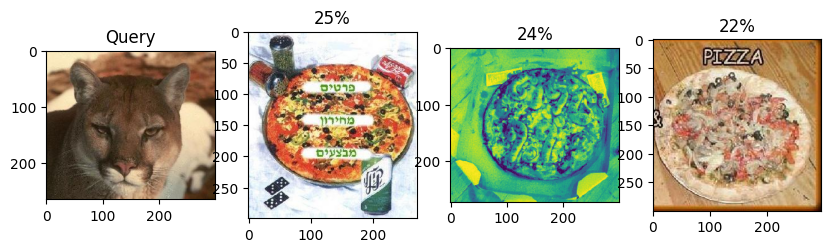

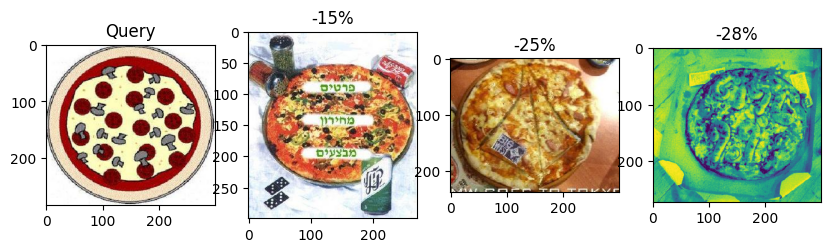

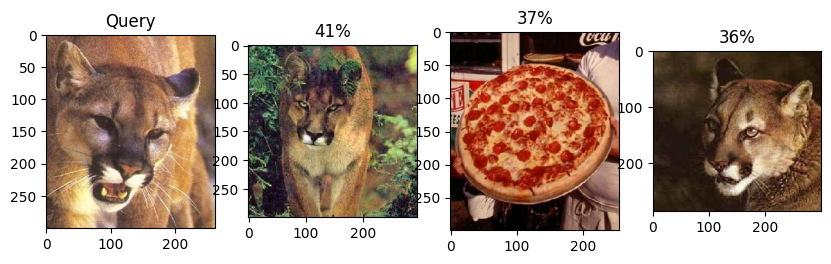

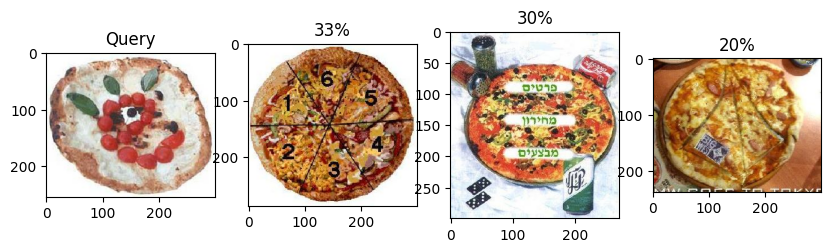

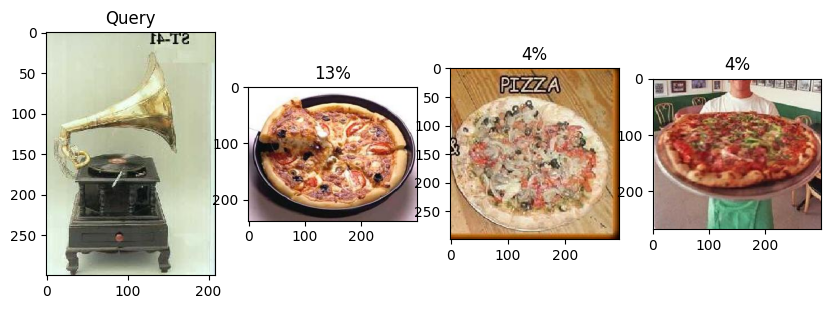

In [63]:
# Bhattacharyya distance

for jpg_path in test_img[:5]:
    test_hist = GenDescriptorClusterHistogram(jpg_path)
    if test_hist is not None:
        similarities = []
        for train_img_idx, train_hist in enumerate(train_histograms):
            # Normalize histograms to sum to 1
            test_hist = test_hist / np.sum(test_hist)
            train_hist = train_hist / np.sum(train_hist)
            # opencv bs:
            test_hist = test_hist.astype(np.float32)
            train_hist = train_hist.astype(np.float32)

            similarity = cv2.compareHist(test_hist, train_hist, cv2.HISTCMP_BHATTACHARYYA) # Bhattacharyya distance in range 0-1, where 0 IS THE MOST SIMILAR
            # similarity = cv2.compareHist(test_hist, train_hist, cv2.HISTCMP_KL_DIV) # Kullback-Leibler divergence
            similarities.append((similarity, train_img_idx))

        # Convert to numpy array for sorting
        similarities = np.array(similarities, dtype=[('similarity', float), ('index', int)])
        # Sort by similarity
        similarities.sort(order='similarity')
        top_n = 3
        # similarities = similarities[:top_n]

        # display the results:
        fig, axis = plt.subplots(1, top_n + 1)
        fig.set_figwidth(10)
        # query image
        axis[0].title.set_text('Query')
        axis[0].imshow(mpimg.imread(jpg_path))
        # predictions
        for i in range(top_n):
            axis[i+1].title.set_text(f'{100 - round(similarities[i][0] * 100)}%')
            axis[i+1].imshow(mpimg.imread(train_imgs[similarities[i][1]]))

        # print(f'{jpg_path} top {top_n} similarities:', list(map(lambda x: (f'{round(x[0] * 100)}%', train_imgs[x[1]]), similarities)))

# This needs to be reworked. Idk how its supposed to work, this is mostly GPT code

In [53]:
# TF-IDF method

# Precompute TF-IDF for each histogram
idf = np.log(train_histograms / (np.count_nonzero(train_histograms > 0, axis=0) + 1))
tf = train_histograms / train_histograms.sum(axis=1, keepdims=True)
training_tfidf_vectors = tf * idf
print(training_tfidf_vectors.shape)
print("Test TF-IDF contains NaN:", np.isnan(training_tfidf_vectors).any())
print(training_tfidf_vectors)

for jpg_path in test_img[:1]:
    test_hist = GenDescriptorClusterHistogram(jpg_path)
    if test_hist is not None:
        # Compute TF for the test histogram
        test_hist_tf = test_hist / np.sum(test_hist)

        # Compute TF-IDF for the test histogram
        test_hist_tfidf = test_hist_tf * idf
        print(test_hist_tfidf.shape)
        print("Test TF-IDF contains NaN:", np.isnan(test_hist_tfidf).any())

        # Compare with training histograms' TF-IDF vectors
        similarities = cosine_similarity(test_hist_tfidf, training_tfidf_vectors)
        print(similarities)

(199, 200)
Test TF-IDF contains NaN: True
[[-0.05143162 -0.03145919 -0.04153388 ... -0.0182731  -0.02561479
  -0.01064249]
 [-0.07115052         nan         nan ...         nan         nan
          nan]
 [-0.03630062 -0.02070927 -0.02418405 ... -0.00471981 -0.02087962
  -0.01103194]
 ...
 [-0.0367247  -0.03105844 -0.04978673 ... -0.03019404 -0.01858071
  -0.01807054]
 [-0.01429986 -0.01421659 -0.03155761 ... -0.02323757 -0.01946222
  -0.03434632]
 [        nan         nan         nan ... -0.0850493  -0.03620327
          nan]]
(199, 200)
Test TF-IDF contains NaN: True


C:\Users\rolan\AppData\Local\Temp\ipykernel_6916\3341633999.py:4: RuntimeWarning: divide by zero encountered in log
  idf = np.log(train_histograms / (np.count_nonzero(train_histograms > 0, axis=0) + 1))
C:\Users\rolan\AppData\Local\Temp\ipykernel_6916\3341633999.py:6: RuntimeWarning: invalid value encountered in multiply
  training_tfidf_vectors = tf * idf
C:\Users\rolan\AppData\Local\Temp\ipykernel_6916\3341633999.py:18: RuntimeWarning: invalid value encountered in multiply
  test_hist_tfidf = test_hist_tf * idf


ValueError: Input contains NaN.